# Exercise 8. Anomaly Detection and Recommender Systems

In this exercise, we will implement **Anomaly Detection and Recommender Systems** and get
to see how it works on data. Before starting on this programming exercise, we strongly
recommend watching the video lectures and completing the review questions for the associated
topics. For details see **ex8.pdf**

We will implement anomaly detection and recommender systems classes **```AnomalyDetector```** and
**```CollaborativeFilteringLearning```** using mathematical concepts and algorithms without using
any ML library then in the following section we will use it in exercise 8 of the course.

The class is split into multiple cells using **```jdc```** package so that notes can be written for
learning and understanding. Complete implementation of the classes are under 
**```src/unsupervised/anomaly_detector.py```** and **```src/unsupervised/recommender_sys.py```**
module of this repository.

Following cell declares the class **```AnomalyDetector```** with its basic attributes and common utility members.

In [1]:
import jdc
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

In [2]:
class AnomalyDetector(object):
    '''
    Anomaly detection implementation.
    '''
    def __init__(self, X):
        '''
        Initialize instance parameters.
    
        Arguments:
          X (m x n float matrix): Data matrix.
        '''
        self.X = X
    
    
    def plot_data_set(self, X, xlim, ylim, title_label=''
                        , x_label='', y_label=''):
        '''
        Plot data points.
    
        Arguments:
          X (m x n float matrix): Data points.
          xlim (float pair): x-axis limit.
          ylim (float pair): y-axis limit.
          title_label (str): Title label.
          x_label (str): X-axis label.
          y_label (str): Y-axis label.
        '''
        plt.title(title_label)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.xlim(xlim)
        plt.ylim(ylim)
        plt.plot(X[:,0], X[:,1], 'bx')
        plt.show()
    
    
    def plot_fit(self, xlim, ylim, title_label='',
                   x_label='', y_label='', outliers=None):
        '''
        Visualize the dataset and its estimated distribution.
        '''
        step_size = 0.5
        u = np.arange(0, 30, step_size)
        v = np.arange(0, 30, step_size)
        xx, yy = np.meshgrid(u, v)
        z = self.multivariate_gaussian(np.c_[xx.ravel(), yy.ravel()])
        z = z.reshape(xx.shape)
    
        plt.title(title_label)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.xlim(xlim)
        plt.ylim(ylim)
    
        if outliers:
          plt.plot(self.X[outliers, 0], self.X[outliers, 1],
                   marker='o', markersize=10, mfc='none')
    
        plt.plot(self.X[:, 0], self.X[:, 1], 'bx');
        plt.contour(xx, yy, z, 10, colors='green')
        plt.show()
    
    
    def _tp(self, pred, yval):
        '''
        tp is the number of true positives: The ground truth
        label says it's an anomaly and our algorithm correctly 
        classified it as an anomaly.
        
        Arguments:
          pred (1d vector): Predicted labels.
          yval (1d vector): Orginal labels.
        
        Return:
          (int): The number of true positives.
        '''
        c = 0
        for p, o in zip(pred, yval):
          if p == True and o == True:
            c += 1
        return c
    
    
    def _fp(self, pred, yval):
        '''
        fp is the number of false positives: The ground
        truth label says it's not an anomaly, but our algorithm
        incorrectly classified it as an anomaly.
    
        Arguments:
          pred (1d vector): Predicted labels.
          yval (1d vector): Orginal labels.
    
        Return:
          (int): The number of false positives.
        '''
        c = 0
        for p, o in zip(pred, yval):
          if p == False and o == True:
            c += 1
        return c
    
    
    def _fn(self, pred, yval):
        '''
        fn is the number of false negatives: The ground 
        truth label says it's an anomaly, but our algorithm 
        incorrectly classified it as not being anomalous.
    
        Arguments:
          pred (1d vector): Predicted labels.
          yval (1d vector): Orginal labels.
    
        Return:
          (int): The number of false negatives.
        '''
        c = 0
        for p, o in zip(pred, yval):
          if p == True and o == False:
            c += 1
        return c

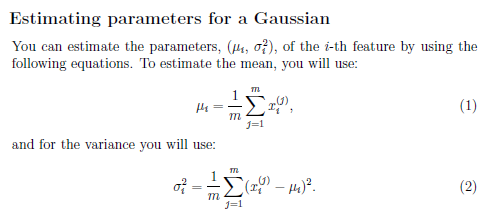

In [3]:
%%add_to AnomalyDetector

def estimate_gaussian_params(self):
    '''
    Estimates the parameters of a Gaussian distribution 
    using the data in X.

    Return:
      (n x 1): Mean vector.
      (n x 1): Sigma^2 vector.
    '''
    m, n = self.X.shape
    self.mu = np.zeros((n, 1))
    self.sigma2 = np.zeros((n, 1))

    self.mu[:,0] = np.mean(self.X, axis=0)
    self.sigma2[:,0] = np.std(self.X, axis=0) ** 2

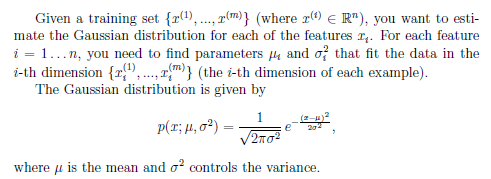

In [4]:
%%add_to AnomalyDetector

def multivariate_gaussian(self, X):
    '''
    Computes the probability density function of the examples X under the 
    multivariate Gaussian distribution with parameters mu and Sigma2. 
    If Sigma2 is a matrix, it is treated as the covariance matrix. If Sigma2
    is a vector, it is treated as the \sigma^2 values of the variances in
    each dimension (a diagonal covariance matrix)

    Arguments:
      (m x n float matrix): Features samples.

    Return
      p(x) values vector.
    '''
    sigma2 = self.sigma2
    if self.sigma2.shape[1] == 1 or self.sigma2.shape[0] == 1:
      sigma2 = np.diag(self.sigma2.reshape((1, self.sigma2.shape[0]))[0])

    # Size of longest dimension.
    k = np.max(self.mu.shape)
    X = X - self.mu.transpose()
    e =  np.exp(-0.5 * np.sum((X.dot(np.linalg.pinv(sigma2)) * X), 1))
    px = (1.0 / (((2.0 * np.pi) ** (k/2)) * (np.linalg.det(sigma2) ** (1/2)))) * e
    return px

In [5]:
%%add_to AnomalyDetector

def select_threshold(self, pval, yval):
    '''
    Find the best threshold (epsilon) to use for selecting
    outliers

    Arguments:
      pval (1d vector): Results from a validation set.
      yval (1d vector): The ground truth.

    Return:
      (float value): Best F1.
      (float value): Best epsilon.
    '''
    best_epsilon = 0.0
    best_F1 = 0.0
    F1 = 0.0

    step_size = (np.max(pval) - np.min(pval)) / 1000
    epsilons = np.arange(min(pval), max(pval), step_size)
    yval = (yval == 1)

    for epsilon in epsilons:
      pred = pval < epsilon
      tp = self._tp(pred, yval)
      fp = self._fp(pred, yval)
      fn = self._fn(pred, yval)

      prec = 0.0
      if tp + fp > 0:
        prec = tp / (tp + fp)

      rec = 0.0
      if tp + fn > 0:
        rec = tp / (tp + fn)

      F1 = 0.0
      if prec + rec > 0:
        F1 = (2.0 * prec * rec) / (prec + rec)

      if F1 > best_F1:
         best_F1 = F1
         best_epsilon = epsilon
    return best_epsilon, best_F1

Following cell declares the class **```CollaborativeFilteringLearning```** with its basic attributes and common utility members.
For details see **```src/unsupervised/recommender_sys.py```**

In [6]:
class CollaborativeFilteringLearning(object):
    '''
    Implementation of Collaborative Filtering Learning Algorithm.
    '''
    def __init__(self, num_users, num_movies, num_features):
        '''
        Initialize instance parameters.
    
        Arguments:
          num_users (int): Number of users.
          num_movies (int): Number of movies.
          num_features (int): Number of features.
        '''
        self.num_users = num_users
        self.num_movies = num_movies
        self.num_features = num_features
    
        # Get set after training.
        self.min_X = None
        self.min_Theta = None
        self.min_cost = None
    
    
    def roll(self, vect):
        '''
        Roll X and Theta matrices.
    
        Arguments:
          vect (vector): Flattened and concatenated X and Theta.
    
        Return:
          (X matrix): Rolled X matrix.
          (Theta matrix): Rolled Theta matrix.
        '''
        X = vect[:self.num_movies * self.num_features].reshape((
                    self.num_movies, self.num_features))
        Theta = vect[self.num_movies * self.num_features:].reshape((
                      self.num_users, self.num_features))
        return X, Theta
    
    
    def unroll(self, X, Theta):
        '''
        Unroll X and Theta into a vector.
    
        Arguments:
          X (matrix): theta1 matrix.
          Theta (matrix): theta2 matrix.
    
        Return:
          (vector): Flattened and concatenated X and Theta.
        '''
        return np.concatenate((X.ravel(), Theta.ravel()))

In [7]:
%%add_to CollaborativeFilteringLearning

def train(self, X, Theta, Y, R, lmda):
    '''
    Train for the collaborative filtering and keep
    learned parameters in instance variable.

    Arguments:
      X (num_movies  x num_features float): Matrix of movies features 
         samples where each row of X corresponds to the feature
         vector x[i] for the i-th movie.
      Theta (num_users  x num_features float): Matrix of user features
        the j-th row of Theta corresponds to one parameter vector theta[j], 
        for the jth user.
      Y (num_movies x num_users float): Stores ratings (from 1 to 5).
      R (): The matrix R is an binary-valued indicator matrix where 
        R[i, j]==1 if user j gave a rating to movie i and.
        R[i, j]==0 if user j didn't give a rating to movie i.
      lmda (float): Regularization parameter lambda.
    '''
    self.min_X = None
    self.min_Theta = None
    self.min_cost = None

    # Initialize theta and args for fmin_cg.
    params = self.unroll(X, Theta)
    args = (Y, R, lmda)

    res = opt.fmin_cg(self.cost, 
                      x0=params, 
                      fprime=self.gradient,
                      args=args, 
                      maxiter=100,
                      disp=False, 
                      full_output=True)
    self.min_X, self.min_Theta = self.roll(res[0])
    self.min_cost = res[1]

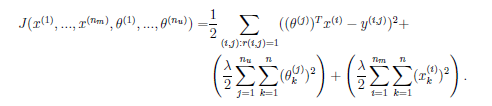

In [8]:
%%add_to CollaborativeFilteringLearning

def cost(self, params, Y, R, lmda):
    '''
    Compute the cost for the collaborative filtering.

    Arguments:
      params (vector float): Combined vector of X and Theta matrix,
        X and Theta flattened and concatenated.
      Y (num_movies x num_users float): Stores ratings (from 1 to 5).
      R (): The matrix R is an binary-valued indicator matrix where 
        R[i, j]==1 if user j gave a rating to movie i and.
        R[i, j]==0 if user j didn't give a rating to movie i.
      lmda (float): Regularization parameter lambda.

    Return:
      (float): Cost value.
    '''
    X, Theta = self.roll(params)

    # Compute cost.
    J = 0.0
    for i in range(self.num_movies):
      xi = X[[i],:]
      for j in range(self.num_users):
        tj = Theta[[j],:]
        if R[i,j] == 1:
          e = (tj.dot(xi.transpose()) - Y[i,j])[0,0]
          J += (e ** 2)
    J *= 0.5

    # Compute regularization term 1.
    reg1 = 0.0
    for j in range(self.num_users):
      for k in range(self.num_features):
        reg1 += (Theta[j,k] ** 2)
    reg1 *= (lmda / 2.0)

    # Compute regularization term 2.
    reg2 = 0.0
    for i in range(self.num_movies):
      for k in range(self.num_features):
        reg2 += (X[i,k] ** 2)
    reg2 *= (lmda / 2.0)

    # Add regularization.
    J += (reg1 + reg2)
    return J

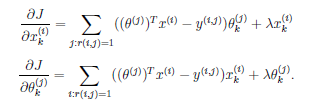

In [9]:
%%add_to CollaborativeFilteringLearning

def gradient(self, params, Y, R, lmda):
    '''
    Compute x gradient for the given 'X' and theta 
    gradient for given 'Theta' for the collaborative filtering.

    Arguments:
      params (1d vector float): Combined vector of X and Theta matrix,
        X and Theta flattened and concatenated.
      Y (num_movies x num_users float): Stores ratings (from 1 to 5).
      R (): The matrix R is an binary-valued indicator matrix where 
        R[i, j]==1 if user j gave a rating to movie i and.
        R[i, j]==0 if user j didn't give a rating to movie i.
      lmda (float): Regularization parameter lambda.

    Returned:
      (1d vector float): X and Theta flattened and concatenated.
    '''
    X, Theta = self.roll(params)

    X_grad = self.__X_grad(X, Theta, Y, R, lmda)
    Theta_grad = self.__Theta_grad(X, Theta, Y, R, lmda)
    return self.unroll(X_grad, Theta_grad)

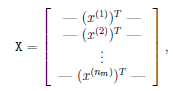

In [10]:
%%add_to CollaborativeFilteringLearning

def __X_grad(self, X, Theta, Y, R, lmda):
    '''
    Compute x gradient for the given 'X'.

    Arguments:
      X (num_movies x num_features float): Matrix of movies features 
         samples where each row of X corresponds to the feature
         vector x[i] for the i-th movie.
      Theta (num_users  x num_features float): Matrix of user features
        the j-th row of Theta corresponds to one parameter vector theta[j], 
        for the jth user.
      Y (num_movies x num_users float): Stores ratings (from 1 to 5).
      R (): The matrix R is an binary-valued indicator matrix where 
        R[i, j]==1 if user j gave a rating to movie i and.
        R[i, j]==0 if user j didn't give a rating to movie i.
      lmda (float): Regularization parameter lambda.

    Return:
      (num_movies x num_features float): Gradient matrix for 'X'
    '''
    X_grad = np.zeros_like(X)

    # Compute X gradient.
    for i in range(self.num_movies):
      xi = X[[i],:]
      for j in range(self.num_users):
        tj = Theta[[j],:]
        if R[i,j] == 1:
          e = (tj.dot(xi.transpose()) - Y[i,j])[0,0]
          for k in range(self.num_features):
            X_grad[i,k] += (e * tj[0,k])
      # Add regularization.
      X_grad[[i],:] += (lmda * xi)
    return X_grad

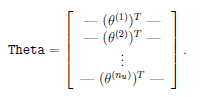

In [11]:
%%add_to CollaborativeFilteringLearning

def __Theta_grad(self, X, Theta, Y, R, lmda):
    '''
    Compute theta gradient for the given 'Theta'.

    Arguments:
      X (num_movies x num_features float): Matrix of movies features 
         samples where each row of X corresponds to the feature
         vector x[i] for the i-th movie.
      Theta (num_users  x num_features float): Matrix of user features
        the j-th row of Theta corresponds to one parameter vector theta[j], 
        for the jth user.
      Y (num_movies x num_users float): Stores ratings (from 1 to 5).
      R (): The matrix R is an binary-valued indicator matrix where 
        R[i, j]==1 if user j gave a rating to movie i and.
        R[i, j]==0 if user j didn't give a rating to movie i.
      lmda (float): Regularization parameter lambda.

    Return:
      (num_users x num_features float): Gradient matrix for 'Theta'
    '''
    Theta_grad = np.zeros_like(Theta)

    # Compute theta gradient.
    for i in range(self.num_movies):
      xi = X[[i],:]
      for j in range(self.num_users):
        tj = Theta[[j],:]
        if R[i,j] == 1:
          e = (tj.dot(xi.transpose()) - Y[i,j])[0,0]
          for k in range(self.num_features):
            Theta_grad[j,k] += (e * xi[0,k])

    # Add regularization.
    for j in range(self.num_users):
      tj = Theta[[j],:]
      Theta_grad[[j],:] += (lmda * tj)
    return Theta_grad

### Course Exercise No 8 'Anomaly Detection and Recommender Systems'. For detailed description of the exercise see "ex8.pdf"
#### This exercise uses the class "AnomalyDetector" and "CollaborativeFilteringLearning" we implemented above.
#### Solution of whole excercise is available in a single class definitions see ```src/exercises/coursera/ex8.py```

## Anomaly detection parts of the exercise

### Some initializations and utility functions for the excercise

In [12]:
datafname1_X = 'data/ex8data1_X.dat'
datafname1_Xval = 'data/ex8data1_Xval.dat'
datafname1_yval = 'data/ex8data1_yval.dat'

datafname2_X = 'data/ex8data2_X.dat'
datafname2_Xval = 'data/ex8data2_Xval.dat'
datafname2_yval = 'data/ex8data2_yval.dat'

datafname_movie_ids = 'data/movie_ids.txt'
datafname_ex8_movies_Y = 'data/ex8_movies_Y.dat'
datafname_ex8_movies_R = 'data/ex8_movies_R.dat'

datafname_ex8_movieparams_X = 'data/ex8_movieParams_X.dat'
datafname_ex8_movieparams_Theta = 'data/ex8_movieParams_Theta.dat'
datafname_ex8_movieparams_num_users = 'data/ex8_movieParams_num_users.dat'
datafname_ex8_movieparams_num_movies = 'data/ex8_movieParams_num_movies.dat'
datafname_ex8_movieparams_num_features = 'data/ex8_movieParams_num_features.dat'


def compute_numerical_gradient(X_Theta_vect, Y, R, lmda, cfl):
    '''
    Compute the numerical gradient of the algorithm around theta.
    Calling cfl.cost(params...) should return the algorithm value
    at theta.

    Arguments:
      X_Theta_vect (1 x n float vector): Pre-calculated X and Theta,
        flattened and concatenated X and Theta.
      Y (num_movies x num_users float): Stores ratings (from 1 to 5).
      R (): The matrix R is an binary-valued indicator matrix where 
        R[i, j]==1 if user j gave a rating to movie i and.
        R[i, j]==0 if user j didn't give a rating to movie i.
      lmda (float): Regularization parameter lambda.
      cfl (CollaborativeFilteringLearning): Instance of the class.

    Return:
      (row vector float): Numerical gradients. 
    '''
    numgrad = np.zeros_like(X_Theta_vect)
    perturb = np.zeros_like(X_Theta_vect)
    e = 1e-4
    p = 0

    for p in range(len(X_Theta_vect)):
      # Set perturbation vector.
      perturb[p] = e
      loss1 = cfl.cost((X_Theta_vect - perturb),Y, R, lmda)
      loss2 = cfl.cost((X_Theta_vect + perturb),Y, R, lmda)

      # Compute Numerical Gradient
      numgrad[p] = (loss2 - loss1) / (2 * e)
      perturb[p] = 0
    return numgrad


def check_gradients(lmda):
    '''
    Create a collaborative filtering problem to check cost function
    and gradients, it will output the analytical gradients produced
    by the code and the numerical gradients (computed using function 
    'self.compute_numerical_gradient'). These two gradient computations
    should result in very similar values.

    Arguments:
      lmda (float): Lambda value for regularization.
    '''
    num_users = 5;
    num_movies = 4;
    num_features = 3;

    # Create small problem.
    X_t = np.random.rand(num_movies, num_features)
    Theta_t = np.random.rand(num_users, num_features)

    # Zap out most entries
    Y = X_t.dot(Theta_t.transpose())
    Y[np.random.rand(Y.shape[0], Y.shape[1]) > 0.5] = 0
    R = np.zeros_like(Y)
    R[np.where(Y != 0)] = 1

    # Run Gradient Checking
    X = np.random.rand(num_movies, num_features)
    Theta = np.random.rand(num_users, num_features)

    cfl = CollaborativeFilteringLearning(num_users, num_movies, num_features)
    # Get gradient empirically.
    X_Theta_vect = cfl.gradient(cfl.unroll(X, Theta), Y, R, lmda)
    # Get gradient numerically.
    num_X_Theta_vect = compute_numerical_gradient(cfl.unroll(X, Theta), Y, R, lmda, cfl)

    # Evaluate the norm of the difference between two solutions.  
    # difference should be less than 1e-9
    diff = np.linalg.norm(num_X_Theta_vect - 
                          X_Theta_vect) / np.linalg.norm(num_X_Theta_vect + 
                                                         X_Theta_vect)
    print('Empirical grad calculation.')
    print(X_Theta_vect)
    print('Numerical grad calculation.')
    print(num_X_Theta_vect)
    print('The relative difference shall be less than 1e-9.')
    print('difference = ' + str(diff) + ' test passed.')


def _load_movie_list():
    '''
    Load and return movie list.

    Return:
      (list): List of movies.
    '''
    movie_list = list()
    f = open(datafname_movie_ids, 'r', encoding='ISO-8859-1')
    for l in f:
      movie_list.append(l[l.find(' '):].strip())
    f.close()
    return movie_list


def _assign_test_movie_ratings(movie_list):
    '''
    Assign some test movie ratings. 

    Arguments:
      (list): Movie list.

    Return:
      (n x 1 vector): Test movie ratings.
    '''
    #  Initialize my ratings
    my_ratings = np.zeros((len(movie_list), 1))

    # We have selected a few movies we liked/did not like
    # and the ratings we gave are as follows.
    my_ratings[0] = 4
    my_ratings[97] = 2;
    my_ratings[6] = 3
    my_ratings[11]= 5
    my_ratings[53] = 4
    
    my_ratings[63]= 5
    my_ratings[65]= 3
    my_ratings[68] = 5
    my_ratings[182] = 4
    my_ratings[225] = 5
    my_ratings[354]= 5

    print('New user test ratings:')
    for i in range(len(my_ratings)):
      if my_ratings[i] > 0:
        print('Rated {} for {}'.format(my_ratings[i], movie_list[i]))
    return my_ratings


def _normalize_movie_ratings(Y, R):
    '''
    Normalized Y so that each movie has a rating 
    of 0 on average, and returns the mean rating in Ymean.

    Preprocess data by subtracting mean rating for every
    movie (every row)

    Arguments:
      Y (num_movies x num_users float): Stores ratings (from 1 to 5).
      R (): The matrix R is an binary-valued indicator matrix where 
        R[i, j]==1 if user j gave a rating to movie i and.
        R[i, j]==0 if user j didn't give a rating to movie i.

    Return:
      (float matrix): Normalized y.
      (n x 1 vector float): Mean values.

    '''
    m, n = Y.shape
    Ymean = np.zeros((m, 1))
    Ynorm = np.zeros_like(Y)

    for i in range(m):
      idx = np.where(R[i, :] == 1)
      Ymean[i] = np.mean(Y[i, idx])
      Ynorm[i,idx] = Y[i,idx] - Ymean[i]
    return Ynorm, Ymean

### Part 1: Load Example Dataset

Visualizing example dataset for outlier detection...


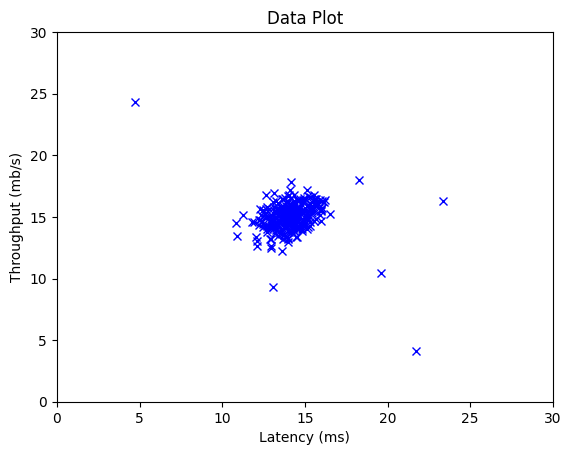

In [13]:
X = np.loadtxt(datafname1_X, delimiter=',')
Xval = np.loadtxt(datafname1_Xval, delimiter=',')
yval = np.loadtxt(datafname1_yval, delimiter=',')

anomaly_det1 = AnomalyDetector(X)
xlim = (0, 30)
ylim = (0, 30)
print('Visualizing example dataset for outlier detection...')
anomaly_det1.plot_data_set(X, xlim, ylim, 'Data Plot',
                           'Latency (ms)', 'Throughput (mb/s)')

### Part 2: Estimate the dataset statistics

Visualizing Gaussian fit...


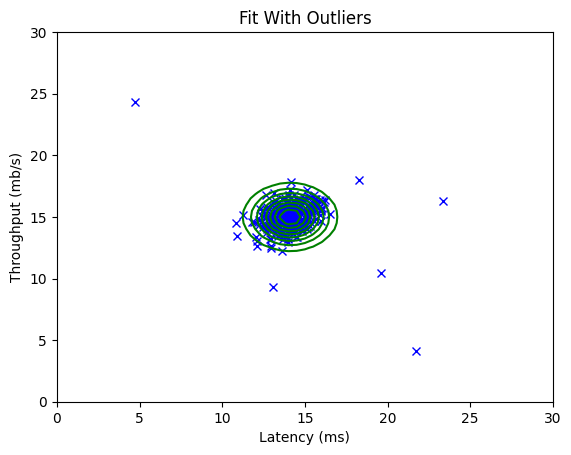

In [14]:
print('Visualizing Gaussian fit...')
anomaly_det1.estimate_gaussian_params()
p = anomaly_det1.multivariate_gaussian(anomaly_det1.X)
anomaly_det1.plot_fit(xlim, ylim, 'Fit With Outliers',
                      'Latency (ms)', 'Throughput (mb/s)')

### Part 3: Find Outliers

You should see a value epsilon of about 8.99e-05.
Best epsilon found using cross-validation: 8.990852779269496e-05 test passed.
Best F1 on Cross Validation Set:  0.8750000000000001


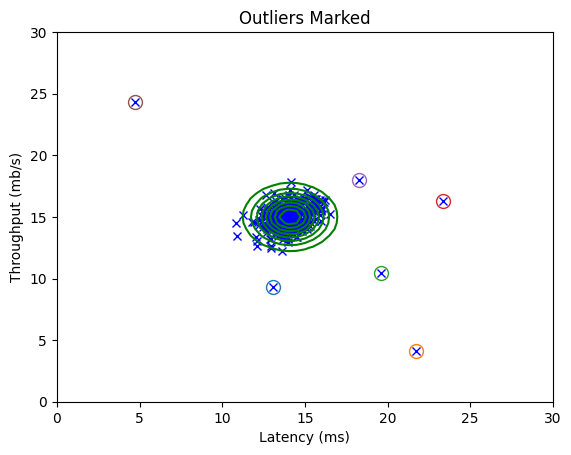

In [15]:
pval = anomaly_det1.multivariate_gaussian(Xval)
epsilon, F1 = anomaly_det1.select_threshold(pval, yval)

print('You should see a value epsilon of about 8.99e-05.')
print('Best epsilon found using cross-validation: {} test passed.'.format(epsilon))
print('Best F1 on Cross Validation Set:  {}'.format(F1))

# Find the outliers in the training set and plot the.
outliers = np.where(p < epsilon);
anomaly_det1.plot_fit(xlim, ylim, 'Outliers Marked', 'Latency (ms)',
                      'Throughput (mb/s)', outliers)

### Part 4: Multidimensional Outliers

In [16]:
# Loads the second dataset. You should now have the
# variables X, Xval, yval in your environment.
X = np.loadtxt(datafname2_X, delimiter=',')
Xval = np.loadtxt(datafname2_Xval, delimiter=',')
yval = np.loadtxt(datafname2_yval, delimiter=',')

anomaly_det2 = AnomalyDetector(X)
# Apply the same steps to the larger dataset.
anomaly_det2.estimate_gaussian_params()
# Training set.
p = anomaly_det2.multivariate_gaussian(anomaly_det2.X)

# Cross-validation set.
pval = anomaly_det2.multivariate_gaussian(Xval)
# Find the best threshold.
epsilon, F1 = anomaly_det2.select_threshold(pval, yval)

print('You should see a value epsilon of about 1.38e-18.')
print('Best epsilon found using cross-validation: {} test passed.'.format(epsilon))
print('Best F1 on Cross Validation Set:  {}'.format(F1))
print('Number of Outliers found: {} test passed.'.format(np.sum(p < epsilon)))

You should see a value epsilon of about 1.38e-18.
Best epsilon found using cross-validation: 1.3772288907613577e-18 test passed.
Best F1 on Cross Validation Set:  0.6153846153846154
Number of Outliers found: 117 test passed.


## Movie ratings parts of the exercise

### Part 1: Loading movie ratings dataset

Y shape = (1682, 943)
R shape = (1682, 943)
Average rating for movie 1 (Toy Story): 4.52067868504772 / 5
Visualizing the ratings matrix...


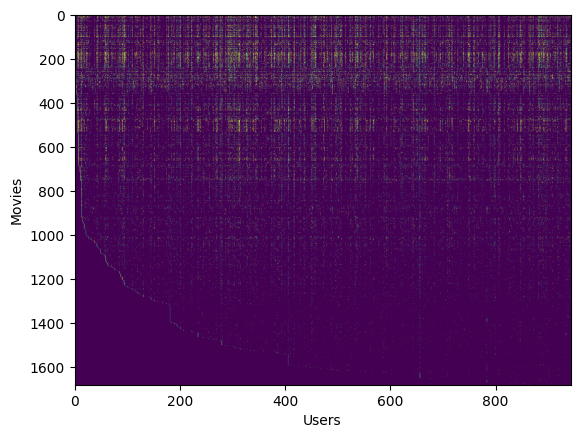

In [17]:
# Y is a 1682x943 matrix, containing ratings (1-5) of 1682
# movies on 943 users.
Y = np.loadtxt(datafname_ex8_movies_Y, delimiter=',')
print('Y shape = {}'.format(Y.shape))
# R is a 1682x943 matrix, where R(i,j) = 1 if and only if user
# j gave a rating to movie i.
R = np.loadtxt(datafname_ex8_movies_R, delimiter=',')
print('R shape = {}'.format(R.shape))

# From the matrix, we can compute statistics like average rating.
print('Average rating for movie 1 (Toy Story): {} / 5'.
      format(np.mean(Y[0, R[0, :].astype(int) ])))

# We can "visualize" the ratings matrix.
print('Visualizing the ratings matrix...')
plt.xlabel('Users')
plt.ylabel('Movies')
plt.imshow(Y, aspect='auto')
plt.show()

### Part 2: Collaborative Filtering Cost Function

In [18]:
# Load pre-trained weights X, Theta, num_users, 
# num_movies and num_features.
X = np.loadtxt(datafname_ex8_movieparams_X, delimiter=',')
Theta = np.loadtxt(datafname_ex8_movieparams_Theta, delimiter=',')
num_users = np.loadtxt(datafname_ex8_movieparams_num_users, delimiter=',')
num_movies = np.loadtxt(datafname_ex8_movieparams_num_movies, delimiter=',')
num_features = np.loadtxt(datafname_ex8_movieparams_num_features, delimiter=',')

# Reduce the data set size so that this runs faster.
num_users = 4
num_movies = 5
num_features = 3
X = X[:num_movies,:num_features]
Theta = Theta[:num_users,:num_features]
Y = Y[:num_movies,:num_users]
R = R[:num_movies,:num_users]

cfl = CollaborativeFilteringLearning(num_users, num_movies, num_features)
lmda = 0
#  Evaluate cost function without regularization.
print('Evaluate cost function without regularization...')
J = cfl.cost(cfl.unroll(X, Theta), Y, R, lmda)
print('Cost at loaded parameters: {} (this value should be about 22.22) test passed.'.format(J))

Evaluate cost function without regularization...
Cost at loaded parameters: 22.224603725685668 (this value should be about 22.22) test passed.


### Part 3: Collaborative Filtering Gradient

In [19]:
print('Checking Gradients without regularization...')
check_gradients(lmda)

Checking Gradients without regularization...
Empirical grad calculation.
[ 1.62212976  1.48637861  1.6730066  -0.56407312 -0.41682945 -0.37135585
  0.56700278  0.46492947  0.51715646  0.03373028  0.02792862  0.0309344
  0.23135982  0.42759862  0.47074989 -0.17165084 -0.04949824 -0.14606088
  0.78123391  0.98424949  1.22623881  0.49545601  0.51514585  0.04644438
  0.20350571  0.27342418  0.33289234]
Numerical grad calculation.
[ 1.62212976  1.48637861  1.6730066  -0.56407312 -0.41682945 -0.37135585
  0.56700278  0.46492947  0.51715646  0.03373028  0.02792862  0.0309344
  0.23135982  0.42759862  0.47074989 -0.17165084 -0.04949824 -0.14606088
  0.78123391  0.98424949  1.22623881  0.49545601  0.51514585  0.04644438
  0.20350571  0.27342418  0.33289234]
The relative difference shall be less than 1e-9.
difference = 4.2237866088099756e-13 test passed.


### Part 4: Collaborative Filtering Cost Regularization

In [20]:
lmda = 1.5
#  Evaluate cost function with regularization.
print('Evaluate cost function with regularization (lambda = {})...'.format(lmda))
J = cfl.cost(cfl.unroll(X, Theta), Y, R, lmda)
print('Cost at loaded parameters: {} (this value should be about 31.34) test passed.'.format(J))

Evaluate cost function with regularization (lambda = 1.5)...
Cost at loaded parameters: 31.344056244274213 (this value should be about 31.34) test passed.


### Part 5: Collaborative Filtering Gradient Regularization

In [21]:
print('Checking Gradients with regularization (lambda = {})...'.format(lmda))
check_gradients(lmda)

Checking Gradients with regularization (lambda = 1.5)...
Empirical grad calculation.
[0.95996986 0.7420761  0.77924668 1.47583212 1.59179828 1.70464841
 1.70174791 2.35338032 1.22912181 0.30308022 1.26951808 1.8756312
 0.68711533 1.02002423 1.91830702 1.72156439 2.51945311 0.99025825
 1.15046982 1.29584137 1.74899867 0.45173512 0.14217698 0.53850005
 0.55813931 1.18901381 1.58595535]
Numerical grad calculation.
[0.95996986 0.7420761  0.77924668 1.47583212 1.59179828 1.70464841
 1.70174791 2.35338032 1.22912181 0.30308022 1.26951808 1.8756312
 0.68711533 1.02002423 1.91830702 1.72156439 2.51945311 0.99025825
 1.15046982 1.29584137 1.74899867 0.45173512 0.14217698 0.53850005
 0.55813931 1.18901381 1.58595535]
The relative difference shall be less than 1e-9.
difference = 1.5639158472425937e-12 test passed.


### Part 6: Entering ratings for a new user

In [22]:
# Before we train the collaborative filtering
# model, we first add ratings that correspond 
# to a new user that we just observed.
movie_list = _load_movie_list()
my_movie_ratings = _assign_test_movie_ratings(movie_list)

New user test ratings:
Rated [4.] for Toy Story (1995)
Rated [3.] for Twelve Monkeys (1995)
Rated [5.] for Usual Suspects, The (1995)
Rated [4.] for Outbreak (1995)
Rated [5.] for Shawshank Redemption, The (1994)
Rated [3.] for While You Were Sleeping (1995)
Rated [5.] for Forrest Gump (1994)
Rated [2.] for Silence of the Lambs, The (1991)
Rated [4.] for Alien (1979)
Rated [5.] for Die Hard 2 (1990)
Rated [5.] for Sphere (1998)


### Part 7: Learning Movie Ratings

In [24]:
# Now train the collaborative filtering model on
# a movie rating dataset of 1682 movies and 943 users.
# Load data.
Y = np.loadtxt(datafname_ex8_movies_Y, delimiter=',')
R = np.loadtxt(datafname_ex8_movies_R, delimiter=',')

# Add our own ratings to the data matrix.
Y = np.append(my_movie_ratings, Y, 1)
my_movie_ratings[np.where(my_movie_ratings != 0)] = 1
R = np.append(my_movie_ratings, R, 1)

# Set initial parameters Theta, X etc
num_users = Y.shape[1]
num_movies = Y.shape[0]
num_features = 10
lmda = 10
X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)

cfl_ratings = CollaborativeFilteringLearning(num_users, num_movies, num_features)
print('\nTraining collaborative filtering...')
print('Please wait (it took almost 45 minutes on my machine)...')
cfl_ratings.train(X, Theta, Y, R , lmda)
print('Recommender system learning completed.')


Training collaborative filtering...
Please wait (it took almost 45 minutes on my machine)...
Recommender system learning completed.


### Part 8: Recommendation for you

In [25]:
# Normalize Ratings
Ynorm, Ymean = _normalize_movie_ratings(Y, R)
p = cfl_ratings.min_X.dot(cfl_ratings.min_Theta.transpose())
my_predictions = p[:,[0]] + Ymean
idx_sorted = np.flipud(np.argsort(my_predictions, axis=0))

print('\nTop recommendations for you:')
for i in range(10):
  j = idx_sorted[i,0]
  print('Predicting rating {0:.1f} for movie {1}.'.format(my_predictions[j,0], movie_list[j]))

print('\nOriginal ratings provided:');
for i in range(my_movie_ratings.shape[0]):
  if my_movie_ratings[i,0] > 0:
    print('Rated {} for {}.'.format(my_movie_ratings[i,0], movie_list[i]))


Top recommendations for you:
Predicting rating 8.5 for movie Titanic (1997).
Predicting rating 8.5 for movie Star Wars (1977).
Predicting rating 8.4 for movie Shawshank Redemption, The (1994).
Predicting rating 8.2 for movie Raiders of the Lost Ark (1981).
Predicting rating 8.2 for movie Schindler's List (1993).
Predicting rating 8.2 for movie Good Will Hunting (1997).
Predicting rating 8.1 for movie Usual Suspects, The (1995).
Predicting rating 8.1 for movie Empire Strikes Back, The (1980).
Predicting rating 8.1 for movie Godfather, The (1972).
Predicting rating 8.0 for movie Braveheart (1995).

Original ratings provided:
Rated 1.0 for Toy Story (1995).
Rated 1.0 for Twelve Monkeys (1995).
Rated 1.0 for Usual Suspects, The (1995).
Rated 1.0 for Outbreak (1995).
Rated 1.0 for Shawshank Redemption, The (1994).
Rated 1.0 for While You Were Sleeping (1995).
Rated 1.0 for Forrest Gump (1994).
Rated 1.0 for Silence of the Lambs, The (1991).
Rated 1.0 for Alien (1979).
Rated 1.0 for Die Har